## Sentiment Analysis of Music Lyrics

This notebook will analyze song lyrics from the top 100 billboard songs from 1964 to 2015.

## TL; DR

In this notebook, you will find:
* Sentiment Analysis using Vader and Sentiment analyzer from nltk
    * The positive, negative, neutral, and compound scores are found for each song in the dataframe.
    * Feel free to explore this link to learn more about Vader: https://blog.quantinsti.com/vader-sentiment/
* Plots of the sentiment scores of the top 100 songs from each year for 50 years.
* Statistical testing (t-test) to find if there is a difference between the sentiments across the years.

### Findings

* Across the positive, negative, and neutral sentiment scores for the song lyrics, the neutral sentiment scores shows a normal distribution while the positive and negative sentiment scores show a distribution that is skewed right. 
* Using the compound sentiment score, there is a visible decrease in the sentiment score as the years go on. This graph suggests that lyrics have a less positive sentiment in more recent years.
    * Years with the lowest compound score: 2004, 2013, and 2015 - tested difference in negative score
    * Years with the highest compound score: 1977, 1978, and 1991 - tested difference in positive score
* Years with conclusive evidence that their positive or negative scores were different than the data set: 2013, 2015, 1977
* Years with inconclusive evidence that their positive or negative scores were different than the data set: 1978, 1991, 2004

### Load Libraries

In [1]:
%pylab inline
import pandas as pd
import scipy.stats as ss
import nltk
from nltk.sentiment import vader, sentiment_analyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('vader_lexicon')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
analyzer = vader.SentimentIntensityAnalyzer()

Populating the interactive namespace from numpy and matplotlib


### Load Data

This may sound bad but I don't remember where I retrieved this dataset. If I had to guess, I got them from Kaggle. The lyrics are already cleaned of punctuation and in lowercase form. Of course, this csv will be included in the repo.

In [71]:
#using latin encoding to import data without error
data = pd.read_csv("billboard_lyrics_1964-2015.csv", encoding='latin-1')

In [97]:
#dropping rows with no lyrics retrieved; will remove nulls and data with excessive spacing
data1 = data.dropna(subset=["Lyrics"])
data1 = data1[~(data1.Lyrics=="  ")&~(data1.Lyrics==" ")]

In [145]:
#just showing rows dropped
print(len(data), len(data1))

5100 4866


### Load Functions

In [146]:
def get_sentiment(data, stop_words):
    """
    Return data with sentiment scores of song lyrics.

        data: data containing the song lyrics. Must have Year and Lyric columns
        stop_words: list pulled from nltk; contains basic words and will be used for removal, i.e. "a","it","the"
        
    This function will tokenize lyric data and analyze the lyric data using Vader lexicon from nltk.
    """
    #create tokens from lyrics
    data["word_tokens"]=data["Lyrics"].apply(word_tokenize)
    #remove stopwords from lyrics
    data["Lyrics_filtered"]=data["word_tokens"].apply(lambda lyrics: " ".join([word for word in lyrics if not word.lower() in stop_words]))
    #calculate sentiment score dataframe - returns positive, neutral, negative, compound scores
    df = data["Lyrics_filtered"].apply(lambda lyrics: analyzer.polarity_scores(lyrics))
    #merges original data with sentiment score dataframe
    data = data.merge(pd.DataFrame(dict(df)).T, left_index=True, right_index=True)
    #filters for columns wanted in final dataset
    data = data[["Year","Lyrics","Lyrics_filtered","neg","neu","pos","compound"]]
    
    return data

## Begin Analysis

### Get Sentiment

In [147]:
#retrieve sentiment scores for lyric data
data2 = get_sentiment(data1, stop_words)
data2.head()

,Year,Lyrics,Lyrics_filtered,neg,neu,pos,compound
0,1965,sam the sham miscellaneous wooly bully wooly b...,sam sham miscellaneous wooly bully wooly bully...,0.430,0.560,0.010,-0.9948
1,1965,sugar pie honey bunch you know that i love yo...,sugar pie honey bunch know love cant help love...,0.191,0.569,0.240,0.9234
3,1965,when i woke up this morning you were on my mi...,woke morning mind mind got troubles whoaoh got...,0.303,0.599,0.099,-0.9607
4,1965,you never close your eyes anymore when i kiss...,never close eyes anymore kiss lips theres tend...,0.085,0.590,0.325,0.9931
5,1965,when youre alone and life is making you lonel...,youre alone life making lonely always go downt...,0.196,0.542,0.262,0.9423


In [105]:
#shows distribution of scores
data2.describe()

,Year,neg,neu,pos,compound
count,4866.000000,4866.000000,4866.000000,4866.000000,4866.000000
mean,1990.310933,0.115939,0.653609,0.230455,0.469237
std,14.698411,0.092808,0.136188,0.133187,0.768280
min,1965.000000,0.000000,0.122000,0.000000,-0.999700
25%,1978.000000,0.048000,0.562250,0.132000,0.000000
50%,1990.000000,0.095000,0.659000,0.210000,0.954550
75%,2003.000000,0.162000,0.749000,0.309000,0.991900
max,2015.000000,0.698000,1.000000,0.878000,0.999900


### Analyze Findings

What I want to know:
* Plot the positive, negative, and neutral sentiment scores and see the patterns
* Plot the compound sentiment scores to see general pattern in sentiment across the years
* Are there any years that the sentiments (pos or neg) were different from all the other years?

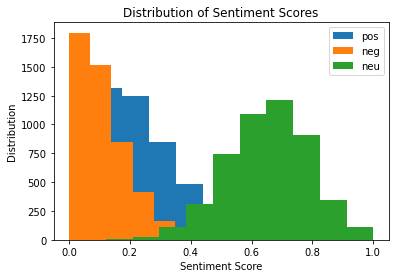

In [234]:
hist(data2["pos"])
hist(data2["neg"])
hist(data2["neu"])
plt.legend(["pos","neg","neu"])
plt.xlabel("Sentiment Score")
plt.ylabel("Distribution")
plt.title("Distribution of Sentiment Scores")
plt.show()

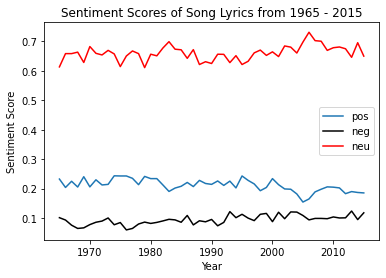

In [175]:
"""
Shows the plots of positive, negative, and neutral sentiment scores. 

I chose to use the median (instead of mean) because there is skewing in the data for positive and negative sentiments (see above).
"""
plot(data2.groupby(by="Year")["pos"].median())
plot(data2.groupby(by="Year")["neg"].median(), c="k")
plot(data2.groupby(by="Year")["neu"].median(), c="r")
plt.legend(["pos","neg","neu"])
plt.title("Sentiment Scores of Song Lyrics from 1965 - 2015")
plt.xlabel("Year")
plt.ylabel("Sentiment Score")
plt.show()

The compound score is a combination of the positive, neutral, and negative scores for each song lyric. In the graph below, compound score is plotted from 1965 through 2015. There are a few downward spikes in the graph. These downward spikes are typical of seeing more negative or less positive sentiments amongst the lyrics. I will compare the scores of the years with big downward spikes and see if there is any difference between their negative scores and the negative scores of all other years.

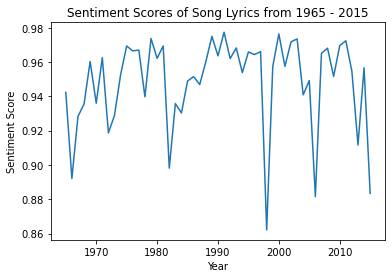

In [167]:
plot(data2.groupby(by="Year")["compound"].median())
plt.title("Sentiment Scores of Song Lyrics from 1965 - 2015")
plt.xlabel("Year")
plt.ylabel("Sentiment Score")
plt.show()

In [197]:
#find 3 years where the spikes occur i.e lowest compound score across 50 years
data2.groupby(by="Year")["compound"].mean().sort_values()[0:3]

Year
2013    0.269274
2015    0.284024
2004    0.284768
Name: compound, dtype: float64

#### Review of the Downward Spike Years
* Find 3 years with the lowest compound score
* Create 3 dataframes (1 for each year) for the years with the lowest compound score
* Perform t-test to retrieve a test statistic and pvalue (are these results significance?)

In [185]:
#find 3 years where the spikes occur i.e lowest compound score across 50 years
data2.groupby(by="Year")["compound"].median().sort_values()[0:3]

Year
1998    0.8621
2006    0.8815
2015    0.8834
Name: compound, dtype: float64

In [186]:
#create dataframe with years with lowest compound score
Y1998 = data2[data2.Year==1998]
Y2006 = data2[data2.Year==2006]
Y2015 = data2[data2.Year==2015]

I decided to perform a t-test on these three years with these hypotheses in mind: 

**Null Hypothesis**: There is no difference between the mean of the negative sentiment scores of the indicated year AND the mean of the negative sentiment scores across all years.

**Alternative Hypothesis**: There is difference between the mean of the negative sentiment scores of the indicated year AND the mean of the negative sentiment scores across all years.

Across these three years, only 2015 proved to be significant with a p-value less than 0.05. I can accept the alternative hypothesis for the year of 2015 meaning there is a difference in the negative sentiment scores compared to other years. For years 1998 and 2006, I do not have conclusive evidence that the alternative hypothesis is true.  

In [224]:
result1 = ss.ttest_1samp(Y1998["neg"],data2["neg"].mean())
result1

Ttest_1sampResult(statistic=1.8489300755160194, pvalue=0.06761100358314458)

In [225]:
result2=ss.ttest_1samp(Y2006["neg"],data2["neg"].mean())
result2

Ttest_1sampResult(statistic=0.500406783032536, pvalue=0.6179459670525507)

In [226]:
result3=ss.ttest_1samp(Y2015["neg"],data2["neg"].mean())
result3

Ttest_1sampResult(statistic=2.6141860355810143, pvalue=0.010369956417844627)

Since the t-test uses the mean to perform the testing, I decided to go back to the graph below and chart the mean of the compound years. This chart looks different than the previous with more ups and downs across the years. I will take the top 3 years with the highest compound scores and the bottom 3 years with the lowest compound scores. I will perform the same tests as above with the same hypotheses. 

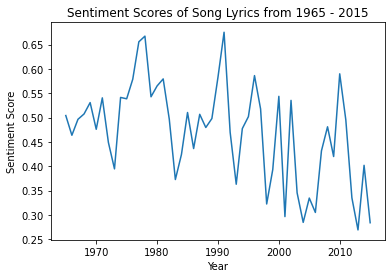

In [198]:
plot(data2.groupby(by="Year")["compound"].mean())
plt.title("Sentiment Scores of Song Lyrics from 1965 - 2015")
plt.xlabel("Year")
plt.ylabel("Sentiment Score")
plt.show()

*Same Hypotheses as Before*

**Null Hypothesis**: There is no difference between the mean of the negative (or positive) sentiment scores of the indicated year AND the mean of the negative sentiment scores across all years.

**Alternative Hypothesis**: There is difference between the mean of the negative (or positive) sentiment scores of the indicated year AND the mean of the negative sentiment scores across all years.

Tests for Years with Lowest Compound Score - Difference in Negative Sentiment (Years 2004, 2013, and 2015)
* Across these three years, 2013 and 2015 proved to be significant with a p-value less than 0.05. I can accept the alternative hypothesis for the years of 2013 and 2015 meaning there is a difference in the negative sentiment scores compared to other years. For year 2004, I do not have conclusive evidence that the alternative hypothesis is true.  


Tests for Years with Highest Compound Score - Difference in Positive Sentiment (Years 1977, 1978, and 1991)
* Across these three years, 1977 proved to be significant with a p-value less than 0.05. I can accept the alternative hypothesis for the year of 1977 meaning there is a difference in the positive sentiment scores compared to other years. For years 1978 and 1991, I do not have conclusive evidence that the alternative hypothesis is true.  

#### Bottom Years

In [235]:
#find 3 years with lowest compound score across 50 years
data2.groupby(by="Year")["compound"].mean().sort_values()[0:3]

Year
2013    0.269274
2015    0.284024
2004    0.284768
Name: compound, dtype: float64

In [203]:
#create dataframe with years with lowest compound score
Y2013 = data2[data2.Year==2013]
Y2004 = data2[data2.Year==2004]
Y2015 = data2[data2.Year==2015]

In [227]:
result1 = ss.ttest_1samp(Y2013["neg"],data2["neg"].mean())
result1

Ttest_1sampResult(statistic=2.423827488777766, pvalue=0.01721109805510746)

In [228]:
result2=ss.ttest_1samp(Y2004["neg"],data2["neg"].mean())
result2

Ttest_1sampResult(statistic=1.8984657896208668, pvalue=0.06060727024181925)

In [229]:
result3=ss.ttest_1samp(Y2015["neg"],data2["neg"].mean())
result3

Ttest_1sampResult(statistic=2.6141860355810143, pvalue=0.010369956417844627)

#### Top Years

In [221]:
#find 3 years with highest compound score across 50 years
data2.groupby(by="Year")["compound"].mean().sort_values(ascending=False)[0:3]

Year
1991    0.675233
1978    0.667203
1977    0.655593
Name: compound, dtype: float64

In [212]:
#create dataframe with years with highest compound score
Y1977 = data2[data2.Year==1977]
Y1978 = data2[data2.Year==1978]
Y1991 = data2[data2.Year==1991]

In [230]:
result1 = ss.ttest_1samp(Y1977["pos"],data2["pos"].mean())
result1

Ttest_1sampResult(statistic=1.993426948072712, pvalue=0.04924271651353981)

In [231]:
result2=ss.ttest_1samp(Y1978["pos"],data2["pos"].mean())
result2

Ttest_1sampResult(statistic=0.8368599394592209, pvalue=0.4048636194424726)

In [232]:
result3=ss.ttest_1samp(Y1991["pos"],data2["pos"].mean())
result3

Ttest_1sampResult(statistic=1.9556036686625595, pvalue=0.05341920730325977)